### Problem Set 4

Yijia Lyu

In [63]:
#import packages
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

### 2.1

In [3]:
#set parameters
A = 1 
alpha = 0.35
beta = 0.442 
delta = 0.6415 
sigma = 3 
labor = np.array([1, 1, 0.2]) 
SS_tol = 1e-9 
f_params = (labor, A, alpha, delta)

In [12]:
def test_fs(f_params, bvec_guess):
    labor, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    K = b2 + b3
    L = np.sum(labor)
    r = get_r(K, L, alpha, delta, A)
    w = get_w(K, L, alpha, A)
    
    c1 = get_cons(0, b2, labor[0], r, w)
    c2 = get_cons(b2, b3, labor[1], r, w)
    c3 = get_cons(b3, 0, labor[2], r, w)
    
    b_cnstr = np.zeros(2, dtype = 'bool')
    c_cnstr = np.zeros(3, dtype = 'bool')
    K_cnstr = ((b2 + b3)<=0)
    
    c_cnstr[0], c_cnstr[1], c_cnstr[2] = (c1<=0), (c2<=0), (c3<=0)
    
    if c_cnstr[0]:
        b_cnstr[0] = 1
    if c_cnstr[1]:
        b_cnstr[0], b_cnstr[1] = 1, 1
    if c_cnstr[2]:
        b_cnstr[1] = 1
        
    return b_cnstr, c_cnstr, K_cnstr

In [8]:
#set functions
get_r = lambda K, L, alpha, delta, A : A * alpha * ((L / K) ** (1 - alpha)) - delta
get_w = lambda K, L, alpha, A: A * (1 - alpha) * ((K / L) ** alpha)
get_K = lambda b2, b3: b2+b3
get_cons = lambda b_s, b_s_1, n_s, r, w: w * n_s + (1 + r) * b_s - b_s_1
get_util = lambda c, sigma=3: (c ** (1-sigma))/(1-sigma)
get_MU = lambda c, sigma=3: c ** (-sigma)
get_Y = lambda K, L, alpha, A: A * (K ** alpha) * (L ** (1-alpha))

### 2.1 a: The constraints for period 1 are violated.

In [13]:
bvec_guess = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = test_fs(f_params, bvec_guess)
print("b_cnstr:", b_cnstr)
print("c_cnstr:", c_cnstr)
print("K_cnstr:", K_cnstr)

b_cnstr: [ True False]
c_cnstr: [ True False False]
K_cnstr: False


### 2.1 b: no constraint is violated

In [14]:
bvec_guess = np.array([0.06, -0.001])
b_cnstr, c_cnstr, K_cnstr = test_fs(f_params, bvec_guess)

print("b_cnstr:", b_cnstr)
print("c_cnstr:", c_cnstr)
print("K_cnstr:", K_cnstr)

b_cnstr: [False False]
c_cnstr: [False False False]
K_cnstr: False


### 2.1 c: no constraint is violated

In [15]:
bvec_guess = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = test_fs(f_params, bvec_guess)

print("b_cnstr:", b_cnstr)
print("c_cnstr:", c_cnstr)
print("K_cnstr:", K_cnstr)

b_cnstr: [False False]
c_cnstr: [False False False]
K_cnstr: False


### 2.2

In [21]:
def EulEq(bvec, args):
    nvec, A, alpha, delta, beta, sigma  = args
    b2, b3 = bvec
    K = sum(bvec)
    L = sum(nvec)
    r = alpha * A * (L / K) ** (1 - alpha) - delta  
    w = (1 - alpha) * A * (K / L) ** alpha
    c1 = w * nvec[0] - bvec_guess[0]
    c2 = w * nvec[1] + (1 + r) * bvec_guess[0] - bvec_guess[1]
    c3 = w * nvec[2] + (1 + r) * bvec_guess[1]
    '''
    mu1 = c1 ** (-sigma)
    mu2 = c2 ** (-sigma)
    mu3 = c3 ** (-sigma)
    
    err1 = mu1 - beta * (1 + r) * mu2
    err2 = mu2 - beta * (1 + r) * mu3
    '''
    
    err1 = (w - b2) ** (-sigma)  - beta * (1 + r) * (w + (1 + r) * b2 - b3) ** (-sigma)
    err2 = (w + (1 + r) * b2 - b3) ** (-sigma) - beta * (1 + r) * (0.2 * w + (1 + r) * b3) ** (-sigma)
    errs = np.array([err1, err2])
    
    return errs

def get_SS(params, bvec_guess, SS_graphs):
    
    start_time = time.time() 
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    args = np.array([nvec, A, alpha, delta, beta, sigma])
    result = opt.root(EulErr, bvec_guess, tol=SS_tol, args = args)
    b_ss = result.x 
    EulErr_ss = result.fun
    b2, b3 = b_ss
    
    K_ss = sum(b_ss)
    r_ss = alpha * A * (L / K_ss) ** (1 - alpha) - delta
    w_ss = (1 - alpha) * A * (K_ss / L) ** alpha
    c1   = w_ss * nvec[0] - b2
    c2   = w_ss * nvec[1] + (1 + r_ss) * b2 - b3
    c3   = w_ss * nvec[2] + (1 + r_ss) * b3 
    c_ss = np.array([c1, c2, c3])
    C_ss = sum(c_ss)
    
    Y_ss = A * K_ss ** alpha * L **(1 - alpha)
    
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.time() - start_time
    
    ss_output = {
    'b_ss': b_ss, 
    'c_ss': c_ss, 
    'w_ss': w_ss, 
    'r_ss': r_ss,
    'K_ss': K_ss, 
    'Y_ss': Y_ss, 
    'C_ss': C_ss,
    'EulErr_ss': EulErr_ss, 
    'RCerr_ss': RCerr_ss,
    'ss_time': ss_time}
    
    if SS_graphs:
        plt.plot((1, 2, 3), (c1, c2, c3), label='Consumption')
        plt.plot((2, 3), (b2, b3), label='Savings')
        plt.title('Steady State Consumption and Savings by Age')
        plt.xlabel('Period')
        plt.ylabel('Amount')
        plt.legend();
    return ss_output

### 2.2 a

In [25]:
params = [beta, sigma, labor, labor.sum(), A, alpha, delta, SS_tol]
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess, False)

In [27]:
print('Savings:',ss_output['b_ss'])
print('Consumptions:',ss_output['c_ss'])
print('Wage:',ss_output['w_ss'])
print('Interest Rate:',ss_output['r_ss'])
print('Capital:',ss_output['K_ss'])
print('Output:',ss_output['Y_ss'])
print('Total Consumption:',ss_output['C_ss'])
print('Euler Errors:',ss_output['EulErr_ss'])
print('Resource Constraint Error:',ss_output['RCerr_ss'])
print('Computation Time:', round(ss_output['ss_time'], 6), 'seconds')

Savings: [0.01931253 0.0584111 ]
Consumptions: [0.18241213 0.20961468 0.24087387]
Wage: 0.20172465739052575
Interest Rate: 2.433062339127069
Capital: 0.07772362575316386
Output: 0.6827603788602411
Total Consumption: 0.6329006729395864
Euler Errors: [-1.39266376e-12  2.62900812e-12]
Resource Constraint Error: 8.326672684688674e-17
Computation Time: 0.00096 seconds


### 2.2 b

{'b_ss': array([0.01931253, 0.0584111 ]),
 'c_ss': array([0.18241213, 0.20961468, 0.24087387]),
 'w_ss': 0.20172465739052575,
 'r_ss': 2.433062339127069,
 'K_ss': 0.07772362575316386,
 'Y_ss': 0.6827603788602411,
 'C_ss': 0.6329006729395864,
 'EulErr_ss': array([-1.39266376e-12,  2.62900812e-12]),
 'RCerr_ss': 8.326672684688674e-17,
 'ss_time': 0.0016589164733886719}

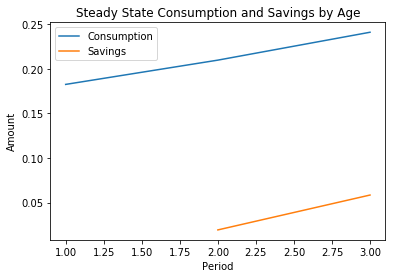

In [28]:
params = [beta, sigma, labor, labor.sum(), A, alpha, delta, SS_tol]
bvec_guess = np.array([0.1, 0.1])
get_SS(params, bvec_guess, SS_graphs=True)

### 2.2 c

In [30]:
params2 = [0.55, sigma, labor, labor.sum(), A, alpha, delta, SS_tol]
ss_output2 = get_SS(params2, bvec_guess, False)
print('Savings:', ss_output2['b_ss'], 'Compared to before:', ss_output['b_ss'])
print('Consumptions:', ss_output2['c_ss'], 'Compared to before:', ss_output['c_ss'])
print('Wage:',ss_output2['w_ss'], 'Compared to before:', ss_output['w_ss'])
print('Interest rate:',ss_output2['r_ss'], 'Compared to before', ss_output['r_ss'])

Savings: [0.02817692 0.07686545] Compared to before: [0.01931253 0.0584111 ]
Consumptions: [0.19597528 0.22861594 0.26669307] Compared to before: [0.18241213 0.20961468 0.24087387]
Wage: 0.22415219593446262 Compared to before: 0.20172465739052575
Interest rate: 1.8863765057190747 Compared to before 2.433062339127069


{'b_ss': array([0.02817692, 0.07686545]),
 'c_ss': array([0.19597528, 0.22861594, 0.26669307]),
 'w_ss': 0.22415219593446262,
 'r_ss': 1.8863765057190747,
 'K_ss': 0.10504237022597478,
 'Y_ss': 0.7586689708551043,
 'C_ss': 0.6912842903551415,
 'EulErr_ss': array([ 5.68434189e-14, -2.84217094e-14]),
 'RCerr_ss': 1.3877787807814457e-17,
 'ss_time': 0.0004978179931640625}

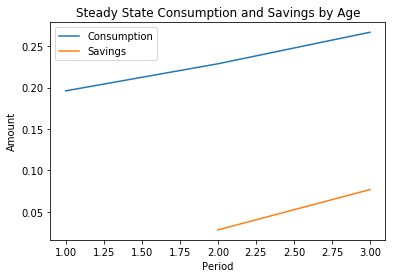

In [31]:
get_SS(params2, bvec_guess, True)

### 2.3 

In [32]:
def timepath(K_path_update, K_init, K_ss, T, A, alpha, delta, labor, m, Type):
    path = np.zeros([T + m, 4])
    period_path  = np.arange(1, T + m +1)
    if Type == "linear":
        K_path = np.linspace(K_init, K_ss, num = T)
    if Type == "update":
        K_path = K_path_update
    path[: , 0] = period_path
    path[: -m, 1] = K_path
    path[-m: , 1] = K_ss
    path[: , 2] = get_w(path[: , 1], labor.sum(), alpha, A)
    path[: , 3] = get_r(path[: , 1], labor.sum(), alpha, delta, A)
    return path

In [34]:
def EulErr(bvec, *args):
    w1, w2, w3, r2, r3, beta, alpha, delta, sigma, A, labor = args
    b2, b3 = bvec
    L = labor.sum()
    K = get_K(b2, b3)
    
    c1 = get_cons(0, b2, labor[0], r2, w1)
    c2 = get_cons(b2, b3, labor[1], r2, w2)
    c3 = get_cons(b3, 0, labor[2], r3, w3)
    
    MU1 = get_MU(c1)
    MU2 = get_MU(c2)
    MU3 = get_MU(c3)
    Eul1 = MU1 - beta*(1+r2) * MU2
    Eul2 = MU2 - beta*(1+r3) * MU3
    Euler_errs = np.array([Eul1, Eul2])
    
    return Euler_errs

In [35]:
def solve_path(path, *args):
    bvec_init_val, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss = args
    b_mat = np.zeros([T + m, 3])
    b_mat[0, 0:-1] = bvec_init_val
    def get_b32(b32, *args):
        r2, r3, b21, w2, w3, beta, sigma, labor = args
        c2  = get_cons(b21, b32, labor[1], r2, w2)
        c3  = get_cons(b32, 0, labor[2], r3, w3)
        MU2 = get_MU(c2)
        MU3 = get_MU(c3)
        error =  MU2 - beta * (1 + r3) * MU3
        return error
    b32_init = 0.1
    b32_args  = (path[0 , 3], path[1 , 3], b_mat[0 , 0], path[0 , 2], path[1 , 2], beta, sigma, labor)
    b32 = opt.root(get_b32, b32_init, args = (b32_args))
    b32 = b32.x
    b_mat[1 , 1] = b32
    for i in range(path.shape[0]-2):
        w1 = path[i - 1 , 2]
        w2 = path[i , 2]
        w3 = path[i + 1 , 2]
        r2 = path[i , 3]
        r3 = path[i + 1, 3]
        ts_args = (w1, w2, w3, r2, r3, beta, alpha, delta, sigma, A, labor)
        bvec_ts = opt.root(EulErr, bvec_init, args = (ts_args))
        b_mat[i , 0] = bvec_ts.x[0]
        b_mat[i + 1, 1] = bvec_ts.x[1]
    b_mat[: , 2] = b_mat[: , 0] + b_mat[: , 1]
    return b_mat

In [36]:
def TPI(path_init, xival, tol, *args):
    bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss, K_ss = args
    b_mat = np.zeros([T + m, 3])
    b_mat[0, 0:-1] = bvec_init
    b_HH_init  = solve_path(path_init, bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss)
    diff_init = sum(((path_init[: -m, 1] - b_HH_init[: -m, 2])/path_init[: -m, 1])**2)
    if diff_init > tol:
        path = path_init
        b_HH = b_HH_init
        diff = diff_init
        iter_num = 0
        while diff > tol:
            update = xival * b_HH[: -m, 2] + (1 - xival) * path[: -m, 1]
            path = timepath(update, 0, K_ss, T, A, alpha, delta, labor, m, "update")
            b_HH = solve_path(path, bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss)
            diff = sum(((path[: -m, 1] - b_HH[: -m, 2])/path[: -m, 1])**2)
            iter_num = iter_num + 1
            print("iteration: ", iter_num, "  difference: ", diff)

        result = (path, b_HH)
    else:
        result =  (path_init, b_HH_init)
    return result

### 2.3 a

In [40]:
#set parameters
xival = 0.1
tol = 1e-9
bvec_init = np.array([0.8 * ss_output['b_ss'][0], 1.1 * ss_output['b_ss'][1]])
T = 25
m = 25
bvec_ss = ss_output['b_ss']
K_ss = ss_output['K_ss']
K_init = bvec_init.sum()
path_init = timepath(0, K_init, K_ss, T, A, alpha, delta, labor, m, "linear")

In [42]:
path = TPI(path_init, xival, tol,  bvec_init, T, m, beta, alpha, delta, sigma, A, labor, bvec_ss, K_ss)

iteration:  1        difference:  0.0026923268543442304
iteration:  2        difference:  0.002157561740107384
iteration:  3        difference:  0.0017408174700849325
iteration:  4        difference:  0.0014142121894262733
iteration:  5        difference:  0.0011567365684827385
iteration:  6        difference:  0.0009525098783005804
iteration:  7        difference:  0.0007894893845593562
iteration:  8        difference:  0.0006585123205853974
iteration:  9        difference:  0.0005525827671266743
iteration:  10        difference:  0.0004663394689037951
iteration:  11        difference:  0.00039565771612220233
iteration:  12        difference:  0.0003373508229514696
iteration:  13        difference:  0.00028894577394323863
iteration:  14        difference:  0.00024851422573664284
iteration:  15        difference:  0.00021454491036903037
iteration:  16        difference:  0.00018584706684335225
iteration:  17        difference:  0.00016147717292832388
iteration:  18        difference:  

In [44]:
K_path = path[0][:, [0 , 1]]
w_path = path[0][:, [0 , 2]]
r_path = path[0][:, [0 , 3]]
b_path = path[1][:,:2]

In [45]:
Eulerr_path = np.zeros((30, 2))
RCerr_path = np.zeros(30)

In [46]:
for i in range(30):
    if i == 0:
        rt = rt1 = r_path[0,1]
        wt = wt1 = w_path[0,1]
        b2t = b2t1 = b_path[0, 0]
        b3t = b3t1 = b_path[0, 1]
    else:
        rt, rt1 = r_path[i, 1], r_path[i-1, 1]
        b2t, b3t = b_path[i,:]
        b2t1, b3t1 = b_path[i-1, :]
        wt, wt1 = w_path[i,1], w_path[i-1, 1]
    Kt = K_path[i,1]
    Kt_1 = K_path[i+1, 1]
    Yt = get_Y(Kt, labor.sum(), alpha, A)
    c1t = get_cons(0, b2t, labor[0], rt, wt)
    c2t = get_cons(b2t1, b3t, labor[1], rt1, wt)
    c3t = get_cons(b3t1, 0, labor[2], rt1, wt)
    Ct = c1t + c2t + c3t
    RCerr_path[i] = Yt - Ct - Kt_1 + (1 - delta) * Kt
    Eulerr_path[i, :] = EulErr(b_path[i, :], w_path[i,1], w_path[i+1,1], 
                               w_path[i+2,1], r_path[i+1,1], r_path[i+2,1], 
                               beta, alpha, delta, sigma, A, labor)

In [57]:
print('Maximum of the absolute values of all the Euler errors is: ', 
      np.abs(Eulerr_path).max())
print('Maximum of the absolute values of all the resource constraint errors is: ', 
      np.abs(RCerr_path).max())

Maximum of the absolute values of all the Euler errors is:  37.40392775466482
Maximum of the absolute values of all the resource constraint errors is:  0.0057734276923919435


### 2.3 b

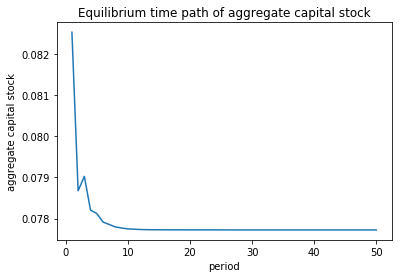

In [52]:
K_fig = plt.figure()
plt.plot(K_path[: , 0], K_path[: , 1])
plt.xlabel('period')
plt.ylabel('aggregate capital stock')
plt.title('Equilibrium time path of aggregate capital stock')
plt.show()

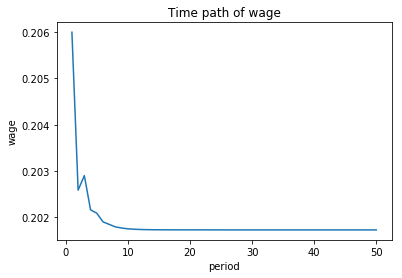

In [53]:
w_fig = plt.figure()
plt.plot(w_path[: , 0], w_path[: , 1])
plt.xlabel('period')
plt.ylabel('wage')
plt.title('Time path of wage')
plt.show()

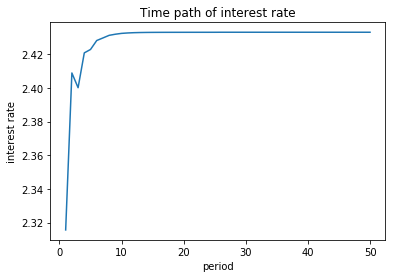

In [54]:
r_fig = plt.figure()
plt.plot(r_path[: , 0], r_path[: , 1])
plt.xlabel('period')
plt.ylabel('interest rate')
plt.title('Time path of interest rate')
plt.show()

### 2.3 c

In [61]:
for i in range(50):
    K = K_path[i, 1]
    if abs(K - K_ss) <= 1e-05:
        print('Time to get within 0.00001 of the steady-state aggregate capital stock is {} periods '.format(int(K_path[i, 0])))
        break

Time to get within 0.00001 of the steady-state aggregate capital stock is 13 periods 


In [62]:
for i in range(50):
    K_mat = K_path[i:, 1]
    Diff = np.abs(K_mat - K_ss)
    if np.sum(Diff > 1e-05) == 0:
        print(" After period {}, the aggregate capital stock never is again farther than 0.00001 away from the steady-state.".format(int(K_path[i, 0])))
        break

 After period 13, the aggregate capital stock never is again farther than 0.00001 away from the steady-state.
